# Custom preprocessing for different imaging technologies

This notebook demonstrates an image registration workflow using the `Twocan` library with custom preprocessors defined. We will register an example same-slide RNA-FISH and IMC image and demonstrate:

1. Writing a custom preprocessor class
1. Registration on non-nuclear channels

In [1]:
import numpy as np
from twocan import RegEstimator, iou_corr_single_objective, get_aligned_coordinates
from twocan.utils import pick_best_registration 
from twocan.plotting import plot_registration, get_merge, AsinhNorm
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import spatialdata as sd
import optuna
from tifffile import imread
from skimage import transform
import spatialdata_plot

/home/harrigan/.conda/envs/twocan/lib/python3.9/site-packages/pyproj/__init__.py:95: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()
/home/harrigan/.conda/envs/twocan/lib/python3.9/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


## Load data

This data comes from [Schulz et al.](https://doi.org/10.1016/j.cels.2017.12.001) we'll read in the tiffs and construct a SpatialData object

In [2]:
import os
os.chdir('/home/harrigan/repair-quant/twocan_repo/notebooks')

In [3]:
fish = np.stack([imread('data/Dapi_IF.tif'), imread('data/PPIB_RNA_IF.tif')])
FISH = sd.models.Image2DModel.parse(data=np.array([transform.rescale(x, 0.2, preserve_range=True, anti_aliasing=True) for x in fish]), c_coords=['DAPI', 'PPIB'])
IMC = sd.models.Image2DModel.parse(data=np.vstack([imread('data/DNA2(Ir193Di).tiff')[None,:,:],imread('data/C2_IMC_PPIB_10nM.tiff')[None,:,:]]), c_coords=['DNA2', 'PPIB'])
sdata = sd.SpatialData({'FISH': FISH, 'IMC': IMC})

INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           
INFO     no axes information specified in the object, setting `dims` to: ('c', 'y', 'x')                           


Note that the FISH image is upsidedown relative to IMC!

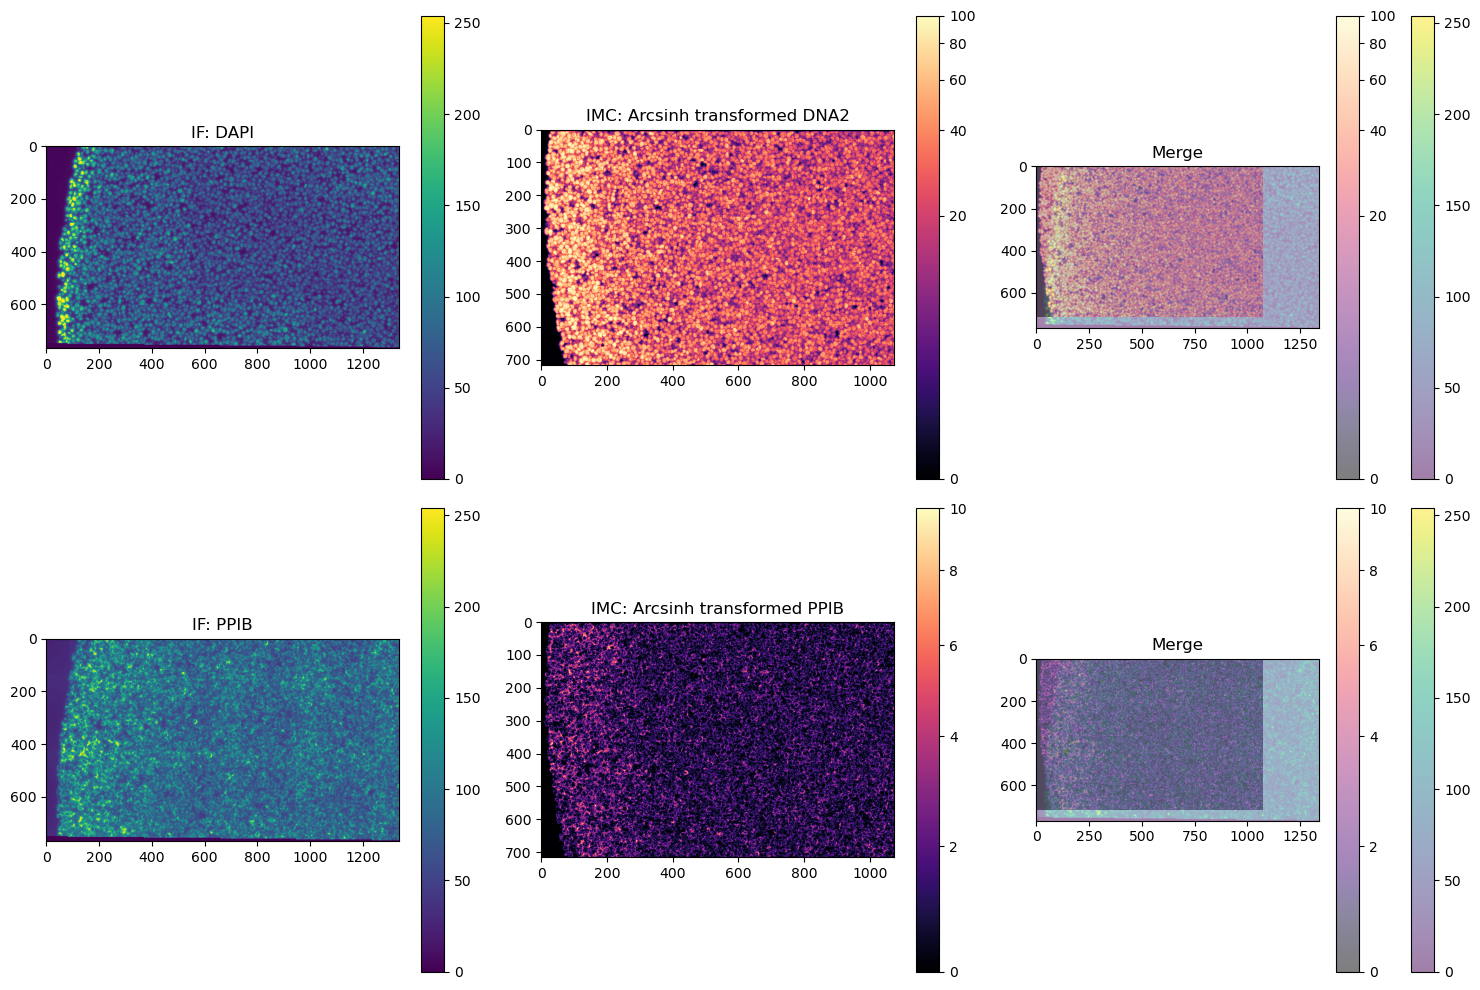

In [9]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
ax1, ax2, ax3 = axs[0]
ax4, ax5, ax6 = axs[1]
sdata.pl.render_images('FISH', channel='DAPI').pl.show(coordinate_systems=["global"], title="IF: DAPI", ax=ax1)
sdata.pl.render_images('IMC', channel='DNA2', cmap='magma', norm=AsinhNorm(vmax=100)).pl.show(coordinate_systems=["global"],title="IMC: Arcsinh transformed DNA2", ax=ax2)
sdata.pl.render_images('FISH', channel='DAPI', alpha = 0.5).pl.show(coordinate_systems=["global"], ax=ax3)
sdata.pl.render_images('IMC', channel='DNA2', cmap='magma', norm=AsinhNorm(vmax=100), alpha = 0.5).pl.show(coordinate_systems=["global"], title="Merge", ax=ax3)
sdata.pl.render_images('FISH', channel='PPIB').pl.show(coordinate_systems=["global"], title="IF: PPIB", ax=ax4)
sdata.pl.render_images('IMC', channel='PPIB', cmap='magma', norm=AsinhNorm(vmax=10)).pl.show(coordinate_systems=["global"],title="IMC: Arcsinh transformed PPIB", ax=ax5)
sdata.pl.render_images('FISH', channel='PPIB', alpha = 0.5).pl.show(coordinate_systems=["global"], ax=ax6)
sdata.pl.render_images('IMC', channel='PPIB', cmap='magma', norm=AsinhNorm(vmax=10), alpha = 0.5).pl.show(coordinate_systems=["global"], title="Merge", ax=ax6)
plt.tight_layout()

Lets define the FISH preprocessor. It should have an init, config, and call methods. 

In [ ]:
def FISHPreprocessor(image, registration_channels):

In [ ]:
class FishProcessor:
    def __init__(self, binarization_threshold=0.1, sigma=1):
        self.binarization_threshold = binarization_threshold
        self.sigma = sigma
        
    def configure(self, trial_params):
        if trial_params:
            # Extract IF-specific parameters from trial params
            if "FISH_gaussian_sigma" in trial_params:
                self.sigma = trial_params["FISH_gaussian_sigma"]
            if "FISH_binarization_threshold" in trial_params:
                self.binarization_threshold = trial_params["FISH_binarization_threshold"]
        return self 
        
    def __call__(self, source_image):
        source_image = source_image.sum(0)
        source_image = source_image / source_image.max()
        source_image = gaussian(source_image, sigma=self.sigma)
        source_image = source_image > self.binarization_threshold
        return source_image

Now, we will modify the trial to propose parameters for FISH preprocessing. We only have to change two lines: these are indicated by `# CHANGE!`

In [10]:
def registration_trial(
    trial, images, registration_channels,
    moving_image='IMC', static_image='IF', 
    moving_preprocessor=IMCProcessor(), static_preprocessor=IFProcessor()
):
       
    # Set up trial parameters
    trial.suggest_float("FISH_binarization_threshold", 0, 1) # CHANGE!
    trial.suggest_float("FISH_gaussian_sigma", 0, 5) # CHANGE!
    trial.suggest_categorical("IMC_arcsinh_normalize", [True, False])
    trial.suggest_float("IMC_arcsinh_cofactor", 1, 100)
    trial.suggest_float("IMC_winsorization_lower_limit", 0, 0.2)
    trial.suggest_float("IMC_winsorization_upper_limit", 0, 0.2)
    trial.suggest_float("IMC_binarization_threshold", 0, 1)
    trial.suggest_float("IMC_gaussian_sigma", 0, 5)
    trial.suggest_categorical("binarize_images", [True])
    trial.suggest_categorical("registration_max_features", [int(1e5)])
    trial.suggest_categorical("registration_percentile", [0.9])
    trial.suggest_categorical("moving_image", [moving_image])
    trial.suggest_categorical("static_image", [static_image])

    # Extract arrays and channels
    source = images[moving_image].to_numpy()
    target = images[static_image].to_numpy()
    source_reg = source[images[moving_image].c.to_index().isin(registration_channels)]
    target_reg = target[images[static_image].c.to_index().isin(registration_channels)]
    
    # Preprocess images
    moving_preprocessor.configure(trial.params)
    static_preprocessor.configure(trial.params)
    source_processed = moving_preprocessor(source_reg)
    target_processed = static_preprocessor(target_reg)

    # list of attributes to set as NaN when trial fails 
    df_na_list = [
        'registration_matrix','prop_source_covered', 'prop_target_covered', 
        'logical_and', 'logical_xor','logical_iou',
        'stack_image_max_corr','reg_image_max_corr',
        'stack_cell_max_corr','reg_cell_max_corr'
    ]

    # Check for invalid preprocessing results
    if (target_processed).all() or (~target_processed).all(): 
        [trial.set_user_attr(k, np.NaN) for k in df_na_list]
        return 
    if (source_processed).all() or (~source_processed).all(): 
        [trial.set_user_attr(k, np.NaN) for k in df_na_list]
        return 
    
    # Register images
    reg = RegEstimator(trial.params["registration_max_features"], trial.params["registration_percentile"])
    try:
        reg.fit(source_processed, target_processed)
    except cv2.error:
        [trial.set_user_attr(k, np.NaN) for k in df_na_list]
        return  
    
    # Check for invalid registration results
    if (reg.M_ is None) or (np.linalg.det(reg.M_[0:2,0:2]) == 0):
        [trial.set_user_attr(k, np.NaN) for k in df_na_list]
        return
    if np.allclose(reg.transform(source_reg), 0):
        [trial.set_user_attr(k, np.NaN) for k in df_na_list]
        return
        
    # Compute registration metrics
    score = reg.score(source_processed, target_processed)

    # Transform and stack images
    stack = reg.transform(source, target)

    # Extract channel-specific stacks
    reg_stack = stack[np.concatenate([
        images[moving_image].c.to_index().isin(registration_channels),
        images[static_image].c.to_index().isin(registration_channels)
    ])]

    # Check for invalid registration results
    if (reg.M_ is None) or (np.linalg.det(reg.M_[0:2,0:2]) == 0):
        [trial.set_user_attr(k, np.NaN) for k in df_na_list]
        return 
    if np.allclose(reg.transform(source_reg), 0):
        [trial.set_user_attr(k, np.NaN) for k in df_na_list]
        return 
    
    def get_max_corr(stack, mask, n_channels):
        corr_matrix = multi_channel_corr(
            stack[:,mask][:n_channels], 
            stack[:,mask][n_channels:]
        )
        if np.all(np.isnan(corr_matrix)):
            return np.nan
        else:
            return np.nanmax(corr_matrix)

    # Image intersection correlations
    mask = reg.transform(np.ones(source_processed.shape), np.ones(target_processed.shape)).sum(0) > 1
    stack_image_max_corr = get_max_corr(stack, mask, source.shape[0])
    reg_image_max_corr = get_max_corr(reg_stack, mask, source_reg.shape[0]) 

    # Pixel intersection correlations  
    mask = reg.transform(source_processed, target_processed).sum(0) > 1
    stack_cell_max_corr = get_max_corr(stack, mask, source.shape[0])
    reg_cell_max_corr = get_max_corr(reg_stack, mask, source_reg.shape[0])

    # Compute registration metrics
    score = reg.score(source_processed, target_processed)
    trial.set_user_attr('registration_matrix', reg.M_)
    trial.set_user_attr('source_sum', score['source_sum'])
    trial.set_user_attr('target_sum', score['target_sum'])
    trial.set_user_attr('logical_and', score['and'])
    trial.set_user_attr('logical_or', score['or'])
    trial.set_user_attr('logical_xor', score['xor'])
    trial.set_user_attr('logical_iou', score['iou'])
    trial.set_user_attr('stack_image_max_corr', stack_image_max_corr)
    trial.set_user_attr('reg_image_max_corr', reg_image_max_corr)
    trial.set_user_attr('stack_cell_max_corr', stack_cell_max_corr)
    trial.set_user_attr('reg_cell_max_corr', reg_cell_max_corr)



NameError: name 'IMCProcessor' is not defined

In [ ]:
def custom_registration_trial(trial, IMC, FISH, registration_channels):
    # source and target are sdata
    # FISH parameters
    FISH_binarization_threshold = trial.suggest_float("FISH_binarization_threshold", 0, 1)
    FISH_gaussian_sigma = trial.suggest_float("FISH_gaussian_sigma", 0, 5)
    # IMC parameters
    IMC_arcsinh_normalize = trial.suggest_categorical("IMC_arcsinh_normalize", [True, False])
    IMC_arcsinh_cofactor = trial.suggest_float("IMC_arcsinh_cofactor", 1, 100) 
    IMC_winsorization_lower_limit = trial.suggest_float("IMC_winsorization_lower_limit", 0, 0.2)
    IMC_winsorization_upper_limit = trial.suggest_float("IMC_winsorization_upper_limit", 0, 0.2)
    IMC_binarization_threshold = trial.suggest_float("IMC_binarization_threshold", 0, 1)
    IMC_gaussian_sigma = trial.suggest_float("IMC_gaussian_sigma", 0, 5)
    # ===============================================
    # do preprocessing for registration
    FISH_reg = FISH[FISH.c.to_index().isin(registration_channels)]
    IMC_reg = IMC[IMC.c.to_index().isin(registration_channels)]
    FISH_processed = preprocess_if(FISH_reg.to_numpy(), 1, True, FISH_binarization_threshold, FISH_gaussian_sigma)
    IMC_processed = preprocess_imc(IMC_reg.to_numpy(), IMC_arcsinh_normalize, IMC_arcsinh_cofactor, [IMC_winsorization_lower_limit, IMC_winsorization_upper_limit], True, IMC_binarization_threshold, IMC_gaussian_sigma)
    return [IMC_processed, FISH_processed]
